In [1]:
import numpy as np

from squlearn import Executor
from squlearn.encoding_circuit import *
from squlearn.kernel import FidelityKernel

In [6]:
circuit1 = LayeredEncodingCircuit(2, 2)
circuit1.Rx("p")
circuit1.Rx("x")

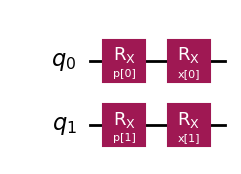

In [15]:
circuit1.draw("mpl")

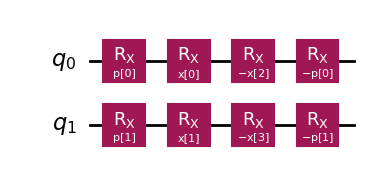

In [13]:
(circuit1.compose(circuit1.inverse())).draw("mpl")

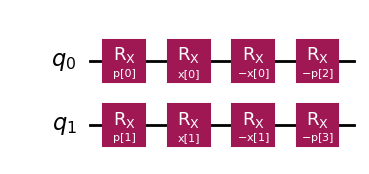

In [8]:
(circuit1+circuit1.inverse()).draw("mpl")

## Testing single variable

In [3]:
executor = Executor("pennylane")

N_samples_x = 7
N_samples_y = 3
n_dim = 1

np.random.seed(42)
x_space = np.random.rand(N_samples_x, n_dim)
y_space = np.random.rand(N_samples_y, n_dim)

circuit1 = LayeredEncodingCircuit(1, 1)
circuit1.Ry("p")
circuit1.Rx("x")

fqk = FidelityKernel(circuit1, executor=executor, caching=False)

p1 = 0.35
fqk.assign_parameters([p1])


def manual_separable_rx_kernel(x, y, p0):
    # RxRy rotation
    # 0.375*(1 - cos(p0))**2*cos(x0 - y0) + 0.125*(1 - cos(p0))**2*cos(x0 + y0) - 0.5*(1 - cos(p0))**2 - 1.0*cos(p0) - 0.3125*cos(x0 - y0) - 0.1875*cos(x0 + y0) - 0.03125*cos(-2*p0 + x0 + y0) + 0.125*cos(-p0 + x0 + y0) + 0.375*cos(p0 - x0 + y0) + 0.375*cos(p0 + x0 - y0) + 0.125*cos(p0 + x0 + y0) + 0.03125*cos(2*p0 - x0 + y0) + 0.03125*cos(2*p0 + x0 - y0) - 0.03125*cos(2*p0 + x0 + y0) + 1.5

    return (
        0.375 * (1 - np.cos(p0)) ** 2 * np.cos(x - y)
        + 0.125 * (1 - np.cos(p0)) ** 2 * np.cos(x + y)
        - 0.5 * (1 - np.cos(p0)) ** 2
        - 1.0 * np.cos(p0)
        - 0.3125 * np.cos(x - y)
        - 0.1875 * np.cos(x + y)
        - 0.03125 * np.cos(-2 * p0 + x + y)
        + 0.125 * np.cos(-p0 + x + y)
        + 0.375 * np.cos(p0 - x + y)
        + 0.375 * np.cos(p0 + x - y)
        + 0.125 * np.cos(p0 + x + y)
        + 0.03125 * np.cos(2 * p0 - x + y)
        + 0.03125 * np.cos(2 * p0 + x - y)
        - 0.03125 * np.cos(2 * p0 + x + y)
        + 1.5
    )


def manual_separable_rx_kernel_dKdx(x, y, p0):
    """
    # RxRy rotation
    """
    return -0.25 * np.sin(x - y) + 0.125 * np.sin(2 * p0 - x + y) - 0.125 * np.sin(2 * p0 + x - y)


def manual_separable_rx_kernel_dKdp(x, y, p0):
    return 0.5 * (1 - np.cos(x - y)) * np.sin(2 * p0)


def manual_separable_rx_kernel_dKdy(x, y, p0):
    return 0.25 * np.sin(x - y) - 0.125 * np.sin(2 * p0 - x + y) + 0.125 * np.sin(2 * p0 + x - y)


def manual_separable_rx_kernel_dKdxdy(x, y, p0):
    return (
        0.375 * (1 - np.cos(p0)) ** 2 * np.cos(x - y)
        + 0.125 * (1 - np.cos(p0)) ** 2 * np.cos(x + y)
        - 0.3125 * np.cos(x - y)
        - 0.1875 * np.cos(x + y)
        - 0.03125 * np.cos(-2 * p0 + x + y)
        + 0.125 * np.cos(-p0 + x + y)
        + 0.375 * np.cos(p0 - x + y)
        + 0.375 * np.cos(p0 + x - y)
        + 0.125 * np.cos(p0 + x + y)
        + 0.03125 * np.cos(2 * p0 - x + y)
        + 0.03125 * np.cos(2 * p0 + x - y)
        - 0.03125 * np.cos(2 * p0 + x + y)
    )


def matrix_manual_todo(x_array, y_array, p0, todo):
    todo = {
        "K": manual_separable_rx_kernel,
        "dKdx": manual_separable_rx_kernel_dKdx,
        "dKdp": manual_separable_rx_kernel_dKdp,
        "dKdy": manual_separable_rx_kernel_dKdy,
        "dKdxdy": manual_separable_rx_kernel_dKdxdy,
    }[todo]
    k_matrix = np.zeros((len(x_array), len(y_array)))
    for i, x in enumerate(x_array):
        for j, y in enumerate(y_array):
            k_matrix[i, j] = todo(x[0], y[0], p0)
    return k_matrix


print(
    "Normal squlearn K == LowQNN implementation K = ",
    np.allclose(
        fqk.evaluate(x_space, y_space),
        fqk.evaluate_derivatives(x_space, y_space, values=["K"])["K"],
    ),
)
print(
    "K_analyical = K_qnn_squlearn = ",
    np.allclose(matrix_manual_todo(x_space, y_space, p1, "K"), fqk.evaluate(x_space, y_space)),
)
print(
    "dKdx_analyical = dKdx_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdx"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdx"])["dKdx"],
    ),
)
print(
    "dKdp_analyical = dKdp_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdp"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdp"])["dKdp"],
    ),
)
print(
    "dKdy_analyical = dKdy_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdy"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdy"])["dKdy"],
    ),
)
print(
    "dKdxdy_analyical = dKdxdy_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdxdy"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdxdy"])["dKdxdy"],
    ),
)

Normal squlearn K == LowQNN implementation K =  True
K_analyical = K_qnn_squlearn =  True
dKdx_analyical = dKdx_qnn_squlearn =  True
dKdp_analyical = dKdp_qnn_squlearn =  True
dKdy_analyical = dKdy_qnn_squlearn =  True
dKdxdy_analyical = dKdxdy_qnn_squlearn =  True


# Testing multi-dimensional

In [3]:
executor = Executor("pennylane")

N_samples_x = 7
N_samples_y = 3
n_dim = 2

np.random.seed(42)
x_space = np.random.rand(N_samples_x, n_dim)
y_space = np.random.rand(N_samples_y, n_dim)

circuit1 = LayeredEncodingCircuit(n_dim, n_dim)
circuit1.Rx("p")
circuit1.Rx("x")

fqk = FidelityKernel(circuit1, executor=executor, caching=False)
p1 = 0.45
fqk.assign_parameters([p1, p1])


def manual_separable_rx_kernel(x, y, p0):
    # Rx(x0)Rx(p0) \otimes Rx(x1)Rx(p0)

    return (
        0.25 * np.cos(x[0] - y[0])
        + 0.25 * np.cos(x[1] - y[1])
        + 0.125 * np.cos(x[0] - x[1] - y[0] + y[1])
        + 0.125 * np.cos(x[0] + x[1] - y[0] - y[1])
        + 0.25
    )


def manual_separable_rx_kernel_dKdx1(x, y, p0):
    return -0.25 * (np.cos(x[1] - y[1]) + 1) * np.sin(x[0] - y[0])


def manual_separable_rx_kernel_dKdx2(x, y, p0):
    return -0.25 * (np.cos(x[0] - y[0]) + 1) * np.sin(x[1] - y[1])


def manual_separable_rx_kernel_dKdy1(x, y, p0):
    # 1.0*sin(x0/2 - y0/2)*cos(x0/2 - y0/2)*cos(x1/2 - y1/2)**2
    return (
        1.0
        * np.sin(x[0] / 2 - y[0] / 2)
        * np.cos(x[0] / 2 - y[0] / 2)
        * np.cos(x[1] / 2 - y[1] / 2) ** 2
    )


def manual_separable_rx_kernel_dKdy2(x, y, p0):
    return (
        1.0
        * np.sin(x[1] / 2 - y[1] / 2)
        * np.cos(x[0] / 2 - y[0] / 2) ** 2
        * np.cos(x[1] / 2 - y[1] / 2)
    )


def matrix_manual_todo(x_array, y_array, p0, todo):
    todo = {
        "K": manual_separable_rx_kernel,
        "dKdx1": manual_separable_rx_kernel_dKdx1,
        "dKdx2": manual_separable_rx_kernel_dKdx2,
        "dKdy1": manual_separable_rx_kernel_dKdy1,
        "dKdy2": manual_separable_rx_kernel_dKdy2,
    }[todo]
    k_matrix = np.zeros((len(x_array), len(y_array)))
    for i, x in enumerate(x_array):
        for j, y in enumerate(y_array):
            k_matrix[i, j] = todo(x, y, p0)
    return k_matrix


print(
    "Normal squlearn K == LowQNN implementation K = ",
    np.allclose(
        fqk.evaluate(x_space, y_space),
        fqk.evaluate_derivatives(x_space, y_space, values=["K"])["K"],
    ),
)
print(
    "K_analyical = K_qnn_squlearn = ",
    np.allclose(matrix_manual_todo(x_space, y_space, p1, "K"), fqk.evaluate(x_space, y_space)),
)
print(
    "dKdx1_analyical = dKdx_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdx1"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdx"])["dKdx"][0],
    ),
)
print(
    "dKdx2_analyical = dKdx_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdx2"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdx"])["dKdx"][1],
    ),
)
print(
    "dKdy1_analyical = dKdy_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdy1"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdy"])["dKdy"][0],
    ),
)
print(
    "dKdy2_analyical = dKdy_qnn_squlearn = ",
    np.allclose(
        matrix_manual_todo(x_space, y_space, p1, "dKdy2"),
        fqk.evaluate_derivatives(x_space, y_space, values=["dKdy"])["dKdy"][1],
    ),
)

Normal squlearn K == LowQNN implementation K =  True
K_analyical = K_qnn_squlearn =  True
dKdx1_analyical = dKdx_qnn_squlearn =  True
dKdx2_analyical = dKdx_qnn_squlearn =  True
dKdy1_analyical = dKdy_qnn_squlearn =  True
dKdy2_analyical = dKdy_qnn_squlearn =  True
